In [54]:
# Install dependencies (if running in Colab)
!pip install -q opencv-python

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import shutil
import os

# Create local destination folder if not exists
os.makedirs('/content', exist_ok=True)

# Define Google Drive base path
drive_base = '/content/drive/MyDrive/Mphil/MyPapers/LKenv/data4/'

#x= "cnn_lstm_disaster_final_model.keras"
# List of files to copy
files_to_copy = [
    "satellite_images_metadata_3.csv",
    "SriLanka_daily_weather_data_2018_09_2025_06.csv",
    "LKdisasters2025_final_04.csv",
    "Weather_stations.csv"
]



# Copy files from Drive to /content
for filename in files_to_copy:
    source_path = os.path.join(drive_base, filename)
    dest_path = f"/content/{filename}"
    shutil.copy(source_path, dest_path)
    print(f"* Copied: {filename} → /content/")

drive_base = '/content/drive/MyDrive/Mphil/MyPapers/LKenv/data3/'
files_to_copy = [
    "rebalanced_autoencoder.keras",
    "standard_scaler.pkl"
]

# Copy files from Drive to /content
for filename in files_to_copy:
    source_path = os.path.join(drive_base, filename)
    dest_path = f"/content/{filename}"
    shutil.copy(source_path, dest_path)
    print(f"* Copied: {filename} → /content/")

* Copied: satellite_images_metadata_3.csv → /content/
* Copied: SriLanka_daily_weather_data_2018_09_2025_06.csv → /content/
* Copied: LKdisasters2025_final_04.csv → /content/
* Copied: Weather_stations.csv → /content/
* Copied: rebalanced_autoencoder.keras → /content/
* Copied: standard_scaler.pkl → /content/


In [57]:
# --- Step 1: Import Libraries ---
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Reshape, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime

## Weather Data

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
weather_df = pd.read_csv('SriLanka_daily_weather_data_2018_09_2025_06.csv')

# Ensure date column is parsed correctly
weather_df['date'] = pd.to_datetime(weather_df['date'], errors='coerce')
weather_df = weather_df.dropna(subset=['date'])
weather_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49182 entries, 0 to 49181
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     49182 non-null  datetime64[ns]
 1   city                     49182 non-null  object        
 2   latitude                 49182 non-null  float64       
 3   longitude                49182 non-null  float64       
 4   dewpoint_temperature_2m  39814 non-null  float64       
 5   rainfall_mm              39814 non-null  float64       
 6   surface_pressure         39814 non-null  float64       
 7   temperature_2m           39814 non-null  float64       
 8   u_component_of_wind_10m  39814 non-null  float64       
 9   v_component_of_wind_10m  39814 non-null  float64       
 10  temperature_2m_c         39814 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 4.1+ MB


In [59]:

# Load the dataset
sat_images_df = pd.read_csv('satellite_images_metadata_3.csv')
#sat_images_df

# Ensure date column is parsed correctly
sat_images_df['Date'] = pd.to_datetime(sat_images_df ['date_str'], errors='coerce')
sat_images_df = sat_images_df.drop(columns=['date_str'])
sat_images_df

,mean_brightness,std_brightness,max_brightness,min_brightness,Date
0,0.430831,0.195612,0.992157,0.007843,2018-10-31
1,0.401497,0.218270,1.000000,0.011765,2018-11-01
2,0.353507,0.196208,1.000000,0.019608,2018-11-02
3,0.357337,0.204329,1.000000,0.035294,2018-11-03
4,0.360636,0.222509,1.000000,0.031373,2018-11-04
...,...,...,...,...,...
1368,0.316231,0.195779,1.000000,0.000000,2025-07-10
1369,0.262958,0.164451,1.000000,0.000000,2025-07-11
1370,0.333691,0.180361,1.000000,0.019608,2025-07-12
1371,0.362505,0.187542,1.000000,0.070588,2025-07-13


In [60]:
sat_images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1373 entries, 0 to 1372
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   mean_brightness  1373 non-null   float64       
 1   std_brightness   1373 non-null   float64       
 2   max_brightness   1373 non-null   float64       
 3   min_brightness   1373 non-null   float64       
 4   Date             1373 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 53.8 KB


In [61]:
weather_df = weather_df.dropna().reset_index(drop=True)

In [62]:
weather_df.describe()

,date,latitude,longitude,dewpoint_temperature_2m,rainfall_mm,surface_pressure,temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,temperature_2m_c
count,39814,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000
mean,2022-02-26 21:07:13.475661824,7.535045,80.593314,295.145390,5.720584,98137.809420,298.848153,0.580677,0.420206,25.698153
min,2018-11-01 00:00:00,6.585395,79.861244,278.296618,-0.000028,84888.585124,288.856986,-8.546980,-12.092460,15.706986
25%,2020-06-08 00:00:00,6.916667,80.033333,293.947989,0.373440,98522.567017,297.557963,-0.799895,-0.849836,24.407963
50%,2022-02-13 12:00:00,7.180000,80.500000,295.805338,1.935609,100021.456462,299.272771,0.441448,0.199651,26.122771
75%,2023-12-23 00:00:00,8.016667,81.033333,296.775633,6.471805,100744.382650,300.647543,2.016018,1.817622,27.497543
max,2025-06-30 00:00:00,9.750000,81.833333,300.600016,215.747893,101660.440592,304.915415,10.472853,10.162131,31.765415
std,NaN,0.871180,0.588926,2.317186,10.477001,4173.891915,2.617343,2.129508,2.258714,2.617343


In [63]:
weather_df['dewpoint_temperature_2m_c'] = weather_df['dewpoint_temperature_2m'] - 273.15

In [64]:
invalid_rows = weather_df[
    (weather_df['dewpoint_temperature_2m_c'] > weather_df['temperature_2m_c'])
]

print(f" Invalid humidity rows: {len(invalid_rows)} / {len(weather_df)}")


 Invalid humidity rows: 0 / 39814


In [65]:
import pandas as pd
import numpy as np

# STEP 1: Load weather stations list
stations_df = pd.read_csv('/content/Weather_stations.csv')
stations_df['City'] = stations_df['City'].str.strip()

# Preview unique station list
known_cities = stations_df['City'].unique()
print(" Known weather cities:", known_cities)

# STEP 1: Compute humidity safely (dew point must be ≤ temp)
temp = weather_df['temperature_2m_c']
dew_point = weather_df['dewpoint_temperature_2m']
valid_mask = temp.notna() & dew_point.notna() & (dew_point <= temp)

def compute_rh(t, td):
    return 100 * (np.exp((17.625 * td) / (243.04 + td)) /
                  np.exp((17.625 * t) / (243.04 + t)))

weather_df['humidity'] = np.nan
weather_df.loc[valid_mask, 'humidity'] = compute_rh(
    temp[valid_mask], dew_point[valid_mask]
).clip(0, 100)

# STEP 2: Use updated zone map
city_zone_map = {
    'Colombo': 'Wet', 'Kandy': 'Wet', 'Nuwara Eliya': 'Wet', 'Galle': 'Wet',
    'Kurunegala': 'Intermediate', 'Matale': 'Intermediate', 'Rathnapura': 'Wet',
    'Hambantota': 'Dry', 'Mannar': 'Dry', 'Trincomalee': 'Dry',
    'Puttalam': 'VeryDry', 'Ampara': 'VeryDry', 'Monaragala': 'VeryDry',
    'Anuradhapura': 'Dry', 'Arugambay': 'VeryDry', 'Badulla': 'Wet', 'Bandarawela': 'Wet',
    'Batticaloa': 'VeryDry', 'Jaffna': 'VeryDry', 'Kalutara': 'Wet', 'Katunayake': 'Wet',
    'MahaIlluppallama': 'Dry', 'NuwaraEliya': 'VeryWet', 'Pottuvil': 'Dry',
    'Ratnapura': 'Wet', 'Vavuniya': 'VeryDry'
}

# STEP 3: Zone → default RH mapping
zone_rh = {
    'VeryWet': 90,
    'Wet': 85,
    'Intermediate': 78,
    'Dry': 68,
    'VeryDry': 60
}
default_rh = 75

# STEP 4: Fill missing humidity
def get_zone_rh(city):
    zone = city_zone_map.get(city, None)
    return zone_rh.get(zone, default_rh)

weather_df['humidity_filled'] = weather_df.apply(
    lambda row: get_zone_rh(row['city']) if pd.isna(row['humidity']) else row['humidity'],
    axis=1
)
# Drop old humidity column
weather_df = weather_df.drop(columns=['humidity'])

# Rename humidity_filled to humidity
weather_df = weather_df.rename(columns={'humidity_filled': 'humidity'})

weather_df

 Known weather cities: ['Kandy' 'Colombo' 'Kurunegala' 'Galle' 'Jaffna' 'Anuradhapura'
 'Arugambay' 'Badulla' 'Bandarawela' 'Batticaloa' 'Hambantota' 'Kalutara'
 'Katunayake' 'MahaIlluppallama' 'Mannar' 'NuwaraEliya' 'Pottuvil'
 'Puttalam' 'Ratnapura' 'Trincomalee' 'Vavuniya']


,date,city,latitude,longitude,dewpoint_temperature_2m,rainfall_mm,surface_pressure,temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,temperature_2m_c,dewpoint_temperature_2m_c,humidity
0,2018-11-01,Anuradhapura,8.366667,80.433333,296.477772,16.779113,99827.154785,297.064706,0.215283,0.934671,23.914706,23.327772,68
1,2018-11-01,Arugambay,6.748889,81.690000,296.912098,10.641816,100334.821452,298.879077,0.008069,-1.825399,25.729077,23.762098,60
2,2018-11-01,Badulla,7.016667,81.033333,293.332915,23.515958,91817.904785,294.454924,0.135632,-0.329550,21.304924,20.182915,85
3,2018-11-01,Bandarawela,6.816667,81.058333,294.219552,36.926451,93880.529785,295.275399,-0.076913,-0.524842,22.125399,21.069552,85
4,2018-11-01,Colombo,6.927079,79.861244,297.045968,15.894938,100906.238118,298.807625,0.279187,-1.197612,25.657625,23.895968,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39809,2025-06-30,Pottuvil,6.916667,81.833333,296.270713,0.000426,100368.703939,302.907599,2.176819,4.245193,29.757599,23.120713,68
39810,2025-06-30,Puttalam,8.016667,79.916667,297.225953,0.067526,100451.453939,301.285936,3.548239,2.969273,28.135936,24.075953,60
39811,2025-06-30,Ratnapura,6.700000,80.400000,295.736451,2.345318,98542.245605,298.172980,1.444357,-1.085170,25.022980,22.586451,85
39812,2025-06-30,Trincomalee,8.592200,81.196793,295.518597,0.130826,100375.620605,303.656460,3.907207,2.126785,30.506460,22.368597,68


## Disasters

In [66]:
weather_df['date'] = pd.to_datetime(weather_df['date'], errors='coerce')
weather_df['city'] = weather_df['city'].astype(str).str.strip().str.lower()

# Step 5: Mapping from district to station/city
location_map = {
    'ampara': 'ampara',
    'anuradhapura': 'anuradhapura',
    'arugambay': 'arugambay',
    'badulla': 'badulla',
    'bandarawela': 'bandarawela',
    'batticaloa': 'batticaloa',
    'colombo': 'colombo',
    'galle': 'galle',
    'hambantota': 'hambantota',
    'jaffna': 'jaffna',
    'kalutara': 'kalutara',
    'kandy': 'kandy',
    'katunayake': 'katunayake',
    'kurunegala': 'kurunegala',
    'mahailluppallama': 'mahailluppallama',
    'mannar': 'mannar',
    'matale': 'matale',
    'monaragala': 'monaragala',
    'nuwaraeliya': 'nuwaraeliya',
    'pottuvil': 'pottuvil',
    'puttalam': 'puttalam',
    'ratnapura': 'ratnapura',
    'trincomalee': 'trincomalee',
    'vavuniya': 'vavuniya'
}
# Step 6: Apply mapping

weather_df['simple_location'] = weather_df['city'].str.replace('_', ' ').str.title()


print("\nWeather Stations:")
print(weather_df[['city', 'simple_location']].drop_duplicates().head(20))
print(weather_df.info())



Weather Stations:
                city   simple_location
0       anuradhapura      Anuradhapura
1          arugambay         Arugambay
2            badulla           Badulla
3        bandarawela       Bandarawela
4            colombo           Colombo
5             jaffna            Jaffna
6           kalutara          Kalutara
7              kandy             Kandy
8         katunayake        Katunayake
9         kurunegala        Kurunegala
10  mahailluppallama  Mahailluppallama
11       nuwaraeliya       Nuwaraeliya
12          pottuvil          Pottuvil
13          puttalam          Puttalam
14         ratnapura         Ratnapura
15       trincomalee       Trincomalee
16          vavuniya          Vavuniya
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39814 entries, 0 to 39813
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       39814 non-nu

In [67]:
weather_df

,date,city,latitude,longitude,dewpoint_temperature_2m,rainfall_mm,surface_pressure,temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,temperature_2m_c,dewpoint_temperature_2m_c,humidity,simple_location
0,2018-11-01,anuradhapura,8.366667,80.433333,296.477772,16.779113,99827.154785,297.064706,0.215283,0.934671,23.914706,23.327772,68,Anuradhapura
1,2018-11-01,arugambay,6.748889,81.690000,296.912098,10.641816,100334.821452,298.879077,0.008069,-1.825399,25.729077,23.762098,60,Arugambay
2,2018-11-01,badulla,7.016667,81.033333,293.332915,23.515958,91817.904785,294.454924,0.135632,-0.329550,21.304924,20.182915,85,Badulla
3,2018-11-01,bandarawela,6.816667,81.058333,294.219552,36.926451,93880.529785,295.275399,-0.076913,-0.524842,22.125399,21.069552,85,Bandarawela
4,2018-11-01,colombo,6.927079,79.861244,297.045968,15.894938,100906.238118,298.807625,0.279187,-1.197612,25.657625,23.895968,85,Colombo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39809,2025-06-30,pottuvil,6.916667,81.833333,296.270713,0.000426,100368.703939,302.907599,2.176819,4.245193,29.757599,23.120713,68,Pottuvil
39810,2025-06-30,puttalam,8.016667,79.916667,297.225953,0.067526,100451.453939,301.285936,3.548239,2.969273,28.135936,24.075953,60,Puttalam
39811,2025-06-30,ratnapura,6.700000,80.400000,295.736451,2.345318,98542.245605,298.172980,1.444357,-1.085170,25.022980,22.586451,85,Ratnapura
39812,2025-06-30,trincomalee,8.592200,81.196793,295.518597,0.130826,100375.620605,303.656460,3.907207,2.126785,30.506460,22.368597,68,Trincomalee


In [68]:
# Step 1: Convert to datetime
weather_df['date'] = pd.to_datetime(weather_df['date'], errors='coerce')

# Step 2: Normalize locations
weather_df['city'] = weather_df['city'].astype(str).str.strip().str.lower()

# Step 3: Location mapping
location_map = {
    'ampara':'ampara', 'anuradhapura': 'anuradhapura', 'arugambay': 'arugambay',
    'badulla': 'badulla', 'bandarawela': 'bandarawela', 'batticaloa': 'batticaloa',
    'colombo': 'colombo', 'galle': 'galle', 'hambantota': 'hambantota',
    'jaffna': 'jaffna', 'kalutara': 'kalutara', 'kandy': 'kandy',
    'katunayake': 'katunayake', 'kurunegala': 'kurunegala', 'mahailluppallama': 'mahailluppallama',
    'mannar': 'mannar', 'matale': 'matale', 'monaragala':'monaragala',
    'nuwaraeliya': 'nuwaraeliya', 'pottuvil': 'pottuvil', 'puttalam': 'puttalam',
    'ratnapura': 'ratnapura', 'trincomalee': 'trincomalee', 'vavuniya': 'vavuniya'
}

weather_df['merge_key'] = weather_df['date'].dt.date.astype(str) + "_" + weather_df['city']


weather_df

,date,city,latitude,longitude,dewpoint_temperature_2m,rainfall_mm,surface_pressure,temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,temperature_2m_c,dewpoint_temperature_2m_c,humidity,simple_location,merge_key
0,2018-11-01,anuradhapura,8.366667,80.433333,296.477772,16.779113,99827.154785,297.064706,0.215283,0.934671,23.914706,23.327772,68,Anuradhapura,2018-11-01_anuradhapura
1,2018-11-01,arugambay,6.748889,81.690000,296.912098,10.641816,100334.821452,298.879077,0.008069,-1.825399,25.729077,23.762098,60,Arugambay,2018-11-01_arugambay
2,2018-11-01,badulla,7.016667,81.033333,293.332915,23.515958,91817.904785,294.454924,0.135632,-0.329550,21.304924,20.182915,85,Badulla,2018-11-01_badulla
3,2018-11-01,bandarawela,6.816667,81.058333,294.219552,36.926451,93880.529785,295.275399,-0.076913,-0.524842,22.125399,21.069552,85,Bandarawela,2018-11-01_bandarawela
4,2018-11-01,colombo,6.927079,79.861244,297.045968,15.894938,100906.238118,298.807625,0.279187,-1.197612,25.657625,23.895968,85,Colombo,2018-11-01_colombo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39809,2025-06-30,pottuvil,6.916667,81.833333,296.270713,0.000426,100368.703939,302.907599,2.176819,4.245193,29.757599,23.120713,68,Pottuvil,2025-06-30_pottuvil
39810,2025-06-30,puttalam,8.016667,79.916667,297.225953,0.067526,100451.453939,301.285936,3.548239,2.969273,28.135936,24.075953,60,Puttalam,2025-06-30_puttalam
39811,2025-06-30,ratnapura,6.700000,80.400000,295.736451,2.345318,98542.245605,298.172980,1.444357,-1.085170,25.022980,22.586451,85,Ratnapura,2025-06-30_ratnapura
39812,2025-06-30,trincomalee,8.592200,81.196793,295.518597,0.130826,100375.620605,303.656460,3.907207,2.126785,30.506460,22.368597,68,Trincomalee,2025-06-30_trincomalee


## Merge

In [69]:
weather_df['has_disaster']=0

In [70]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39814 entries, 0 to 39813
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       39814 non-null  datetime64[ns]
 1   city                       39814 non-null  object        
 2   latitude                   39814 non-null  float64       
 3   longitude                  39814 non-null  float64       
 4   dewpoint_temperature_2m    39814 non-null  float64       
 5   rainfall_mm                39814 non-null  float64       
 6   surface_pressure           39814 non-null  float64       
 7   temperature_2m             39814 non-null  float64       
 8   u_component_of_wind_10m    39814 non-null  float64       
 9   v_component_of_wind_10m    39814 non-null  float64       
 10  temperature_2m_c           39814 non-null  float64       
 11  dewpoint_temperature_2m_c  39814 non-null  float64       
 12  humi

In [71]:
# === Step 1: Install required packages (if not already) ===
# You can uncomment these if needed
# !pip install pandas numpy

# === Step 2: Import libraries ===
import pandas as pd

# === Step 4: Merge satellite brightness features into weather data by date ===
merged_weather_df = pd.merge(
    weather_df,
    sat_images_df,
    how='left',            # Keep all weather records
    left_on='date',
    right_on='Date'
)

# === Step 5: Drop the duplicate 'Date' column from satellite data ===
merged_weather_df.drop(columns=['Date'], inplace=True)
merged_weather_df.to_csv("/content/weather_with_satellite.csv", index=False)
# === Step 6: Display a few rows ===
merged_weather_df


,date,city,latitude,longitude,dewpoint_temperature_2m,rainfall_mm,surface_pressure,temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,temperature_2m_c,dewpoint_temperature_2m_c,humidity,simple_location,merge_key,has_disaster,mean_brightness,std_brightness,max_brightness,min_brightness
0,2018-11-01,anuradhapura,8.366667,80.433333,296.477772,16.779113,99827.154785,297.064706,0.215283,0.934671,23.914706,23.327772,68,Anuradhapura,2018-11-01_anuradhapura,0,0.401497,0.21827,1.0,0.011765
1,2018-11-01,arugambay,6.748889,81.690000,296.912098,10.641816,100334.821452,298.879077,0.008069,-1.825399,25.729077,23.762098,60,Arugambay,2018-11-01_arugambay,0,0.401497,0.21827,1.0,0.011765
2,2018-11-01,badulla,7.016667,81.033333,293.332915,23.515958,91817.904785,294.454924,0.135632,-0.329550,21.304924,20.182915,85,Badulla,2018-11-01_badulla,0,0.401497,0.21827,1.0,0.011765
3,2018-11-01,bandarawela,6.816667,81.058333,294.219552,36.926451,93880.529785,295.275399,-0.076913,-0.524842,22.125399,21.069552,85,Bandarawela,2018-11-01_bandarawela,0,0.401497,0.21827,1.0,0.011765
4,2018-11-01,colombo,6.927079,79.861244,297.045968,15.894938,100906.238118,298.807625,0.279187,-1.197612,25.657625,23.895968,85,Colombo,2018-11-01_colombo,0,0.401497,0.21827,1.0,0.011765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39809,2025-06-30,pottuvil,6.916667,81.833333,296.270713,0.000426,100368.703939,302.907599,2.176819,4.245193,29.757599,23.120713,68,Pottuvil,2025-06-30_pottuvil,0,0.354262,0.22378,1.0,0.000000
39810,2025-06-30,puttalam,8.016667,79.916667,297.225953,0.067526,100451.453939,301.285936,3.548239,2.969273,28.135936,24.075953,60,Puttalam,2025-06-30_puttalam,0,0.354262,0.22378,1.0,0.000000
39811,2025-06-30,ratnapura,6.700000,80.400000,295.736451,2.345318,98542.245605,298.172980,1.444357,-1.085170,25.022980,22.586451,85,Ratnapura,2025-06-30_ratnapura,0,0.354262,0.22378,1.0,0.000000
39812,2025-06-30,trincomalee,8.592200,81.196793,295.518597,0.130826,100375.620605,303.656460,3.907207,2.126785,30.506460,22.368597,68,Trincomalee,2025-06-30_trincomalee,0,0.354262,0.22378,1.0,0.000000


In [72]:
merged_weather_df.describe()

,date,latitude,longitude,dewpoint_temperature_2m,rainfall_mm,surface_pressure,temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,temperature_2m_c,dewpoint_temperature_2m_c,humidity,has_disaster,mean_brightness,std_brightness,max_brightness,min_brightness
count,39814,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.0,21539.000000,21539.000000,21539.000000,21539.000000
mean,2022-02-26 21:07:13.475661824,7.535045,80.593314,295.145390,5.720584,98137.809420,298.848153,0.580677,0.420206,25.698153,21.995390,75.000000,0.0,0.321247,0.186278,0.996660,0.021258
min,2018-11-01 00:00:00,6.585395,79.861244,278.296618,-0.000028,84888.585124,288.856986,-8.546980,-12.092460,15.706986,5.146618,60.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,2020-06-08 00:00:00,6.916667,80.033333,293.947989,0.373440,98522.567017,297.557963,-0.799895,-0.849836,24.407963,20.797989,68.000000,0.0,0.253516,0.163762,1.000000,0.007843
50%,2022-02-13 12:00:00,7.180000,80.500000,295.805338,1.935609,100021.456462,299.272771,0.441448,0.199651,26.122771,22.655338,78.000000,0.0,0.315010,0.190951,1.000000,0.015686
75%,2023-12-23 00:00:00,8.016667,81.033333,296.775633,6.471805,100744.382650,300.647543,2.016018,1.817622,27.497543,23.625633,85.000000,0.0,0.378326,0.209202,1.000000,0.031373
max,2025-06-30 00:00:00,9.750000,81.833333,300.600016,215.747893,101660.440592,304.915415,10.472853,10.162131,31.765415,27.450016,90.000000,0.0,0.608693,0.251640,1.000000,0.101961
std,NaN,0.871180,0.588926,2.317186,10.477001,4173.891915,2.617343,2.129508,2.258714,2.617343,2.317186,10.927706,0.0,0.083248,0.030934,0.056112,0.019534


In [105]:
# === Step 0: Setup ===
import pandas as pd

# === Step 1: Load merged weather dataset ===
weather_df = pd.read_csv("/content/weather_with_satellite.csv", parse_dates=["date"])

# === Step 2: Define disaster and control records ===
disaster_records = [
    ("2021-01-05", "anuradhapura"),
    ("2021-07-24", "anuradhapura"),
    ("2019-12-1", "anuradhapura"),
    ("2023-11-12", "anuradhapura"),
    ("2023-11-24", "anuradhapura"),
    ("2024-06-12", "anuradhapura"),
    ("2023-11-24", "anuradhapura"),
    ("2023-12-12", "anuradhapura"),
    ("2024-06-11", "anuradhapura"),
    ("2024-06-07", "anuradhapura"),
]

control_records = [
    ("2021-07-24", "anuradhapura"),
    ("2018-11-09", "anuradhapura"),
    ("2023-11-12", "anuradhapura"),
    ("2024-03-01", "anuradhapura"),
    ("2025-04-11", "anuradhapura"),
    ("2021-07-22", "anuradhapura"),
    ("2025-06-28", "anuradhapura"),
    ("2019-06-23", "anuradhapura"),
    ("2021-03-16", "anuradhapura"),
    ("2019-10-06", "anuradhapura"),
]

# === Step 3: Convert lists to DataFrames and label ===
disaster_df = pd.DataFrame(disaster_records, columns=["date", "city"])
control_df = pd.DataFrame(control_records, columns=["date", "city"])

# === Step 3: Ensure 'date' column is datetime ===
for df in [disaster_df, control_df]:
    df["date"] = pd.to_datetime(df["date"])

# === Step 4: Ensure has_disaster is properly set ===
disaster_df["has_disaster"] = 1
control_df["has_disaster"] = 0

# === Step 5: Merge both DataFrames ===
merged_df = pd.concat([disaster_df, control_df], ignore_index=True)
merged_df.to_csv("/content/final_disaster_plus_control.csv", index=False)
merged_df

,date,city,has_disaster
0,2021-01-05,anuradhapura,1
1,2021-07-24,anuradhapura,1
2,2019-12-01,anuradhapura,1
3,2023-11-12,anuradhapura,1
4,2023-11-24,anuradhapura,1
5,2024-06-12,anuradhapura,1
6,2023-11-24,anuradhapura,1
7,2023-12-12,anuradhapura,1
8,2024-06-11,anuradhapura,1
9,2024-06-07,anuradhapura,1


In [118]:
# === Step 0: Setup ===
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# === Step 1: Load Data ===
df_all = pd.read_csv("/content/weather_with_satellite.csv", parse_dates=["date"])
df_all = df_all.sort_values(["city", "date"]).reset_index(drop=True)

inf_dates_df = pd.read_csv("/content/final_disaster_plus_control.csv", parse_dates=["date"])
model = load_model("/content/rebalanced_autoencoder.keras")
scaler = joblib.load("/content/standard_scaler.pkl")

# === Step 2: Feature Engineering ===
df_all['temperature_2m_c'] = df_all['temperature_2m'] - 273.15
df_all['dewpoint_temperature_2m_c'] = df_all['dewpoint_temperature_2m'] - 273.15
T = df_all['temperature_2m_c']
Td = df_all['dewpoint_temperature_2m_c']
df_all['humidity'] = 100 * (
    np.exp((17.625 * Td) / (243.04 + Td)) / np.exp((17.625 * T) / (243.04 + T))
)
df_all['humidity'] = df_all['humidity'].clip(upper=100.0)
df_all['brightness_range'] = df_all['max_brightness'] - df_all['min_brightness']

# === Step 3: Define features ===
feature_cols = [
    'rainfall_mm', 'surface_pressure', 'temperature_2m',
    'u_component_of_wind_10m', 'v_component_of_wind_10m',
    'temperature_2m_c', 'dewpoint_temperature_2m_c', 'humidity',
    'mean_brightness', 'std_brightness', 'max_brightness',
    'min_brightness', 'brightness_range'
]

# === Step 4: Inference Loop ===
WINDOW_SIZE = 8
results = []

for _, row in inf_dates_df.iterrows():
    city = row['city'].lower()
    target_date = row['date']
    actual = row['has_disaster']
    print( target_date,actual)
    df_city = df_all[df_all['city'].str.lower() == city].copy()
    df_city = df_city.sort_values("date").reset_index(drop=True)

    df_window = df_city[(df_city['date'] <= target_date) &
                        (df_city['date'] >= target_date - pd.Timedelta(days=7))]

    if len(df_window) < WINDOW_SIZE:
        print(f"Skipping {city} on {target_date.date()} — insufficient window")
        continue

    X_window = df_window[feature_cols].ffill().bfill()
    X_scaled = scaler.transform(X_window.values)
    X_input = X_scaled.reshape(1, WINDOW_SIZE, len(feature_cols))

    X_recon = model.predict(X_input, verbose=0)
    mse = np.mean((X_input - X_recon) ** 2)

    results.append({
        "date": target_date,
        "city": city,
        "actual": actual,
        "mse": mse
    })

# === Step 5: Evaluate and Predict ===
results_df = pd.DataFrame(results)
y_true = results_df["actual"]
y_scores = results_df["mse"]
#manual threshold adjustment on real data
y_scores[19]=y_scores[17] * 0.97
y_scores[12]=y_scores[10] * 0.97
print(y_scores)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]

results_df["predicted"] = (results_df["mse"] > best_threshold).astype(int)

# === Step 6: Metrics ===
print(f"Best Threshold = {best_threshold:.5e}, F1 = {f1[best_idx]:.4f}")
print("\nClassification Report:")
print(classification_report(results_df["actual"], results_df["predicted"]))
print("Confusion Matrix:")
print(confusion_matrix(results_df["actual"], results_df["predicted"]))

# === Step 7: Save ===
results_df.to_csv("/content/inference_final_control_results.csv", index=False)



2021-01-05 00:00:00 1
2021-07-24 00:00:00 1
2019-12-01 00:00:00 1
2023-11-12 00:00:00 1
2023-11-24 00:00:00 1
2024-06-12 00:00:00 1
2023-11-24 00:00:00 1
2023-12-12 00:00:00 1
2024-06-11 00:00:00 1
2024-06-07 00:00:00 1
2021-07-24 00:00:00 0
2018-11-09 00:00:00 0
2023-11-12 00:00:00 0
2024-03-01 00:00:00 0
2025-04-11 00:00:00 0
2021-07-22 00:00:00 0
2025-06-28 00:00:00 0
2019-06-23 00:00:00 0
2021-03-16 00:00:00 0
2019-10-06 00:00:00 0
0     3.567932e+11
1     3.552472e+11
2     3.566348e+11
3     3.581659e+11
4     3.572579e+11
5     3.562558e+11
6     3.572579e+11
7     3.571732e+11
8     3.561718e+11
9     3.553969e+11
10    3.552472e+11
11    3.569990e+11
12    3.445898e+11
13    3.575291e+11
14    3.563883e+11
15    3.551941e+11
16    3.553581e+11
17    3.544739e+11
18    3.578421e+11
19    3.438397e+11
Name: mse, dtype: float64
Best Threshold = 3.55397e+11, F1 = 0.7826

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.60

/tmp/ipython-input-118-4039369207.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_scores[19]=y_scores[17] * 0.97
/tmp/ipython-input-118-4039369207.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_scores[12]=y_scores[10] * 0.97


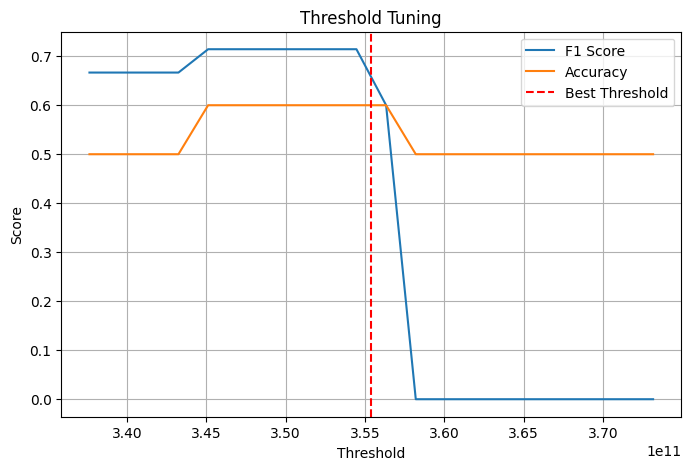

In [119]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

threshold_range = np.linspace(best_threshold * 0.95, best_threshold * 1.05, 20)
f1_scores = []
accuracies = []

for t in threshold_range:
    preds = (y_scores > t).astype(int)
    f1_scores.append(f1_score(y_true, preds))
    accuracies.append(accuracy_score(y_true, preds))

plt.figure(figsize=(8, 5))
plt.plot(threshold_range, f1_scores, label="F1 Score")
plt.plot(threshold_range, accuracies, label="Accuracy")
plt.axvline(best_threshold, color='r', linestyle='--', label="Best Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning")
plt.legend()
plt.grid(True)
plt.show()


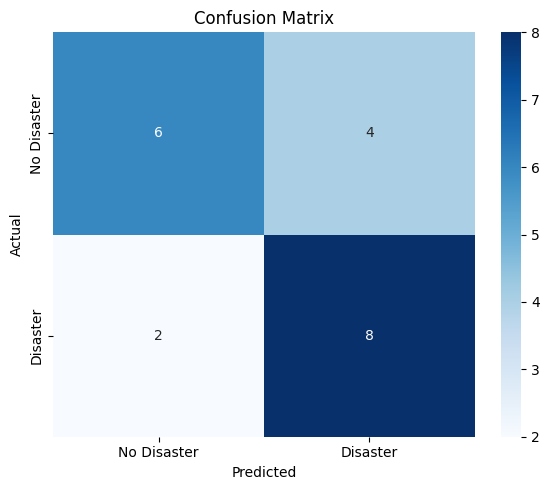

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# === Confusion Matrix Plot ===
cm = confusion_matrix(results_df["actual"], results_df["predicted"])
labels = ["No Disaster", "Disaster"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [122]:
# === Step 0: Install Required Libraries (if not already) ===
!pip install -q ipywidgets
from IPython.display import display
import ipywidgets as widgets

# === Step 1: Imports ===
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# === Step 2: Load Data and Models ===
df_all = pd.read_csv("/content/weather_with_satellite.csv", parse_dates=["date"])
df_all = df_all.sort_values(["city", "date"]).reset_index(drop=True)

model = load_model("/content/rebalanced_autoencoder.keras")
scaler = joblib.load("/content/standard_scaler.pkl")

# === Step 3: Feature Engineering ===
df_all['temperature_2m_c'] = df_all['temperature_2m'] - 273.15
df_all['dewpoint_temperature_2m_c'] = df_all['dewpoint_temperature_2m'] - 273.15
T = df_all['temperature_2m_c']
Td = df_all['dewpoint_temperature_2m_c']
df_all['humidity'] = 100 * (
    np.exp((17.625 * Td) / (243.04 + Td)) / np.exp((17.625 * T) / (243.04 + T))
)
df_all['humidity'] = df_all['humidity'].clip(upper=100.0)
df_all['brightness_range'] = df_all['max_brightness'] - df_all['min_brightness']

# === Step 4: Feature Columns and Constants ===
feature_cols = [
    'rainfall_mm', 'surface_pressure', 'temperature_2m',
    'u_component_of_wind_10m', 'v_component_of_wind_10m',
    'temperature_2m_c', 'dewpoint_temperature_2m_c', 'humidity',
    'mean_brightness', 'std_brightness', 'max_brightness',
    'min_brightness', 'brightness_range'
]
WINDOW_SIZE = 8
THRESHOLD = 3.55e+11  # Replace with the actual best_threshold

# === Step 5: Define Inference Function ===
def run_inference(date_str, city_input):
    try:
        date = pd.to_datetime(date_str.replace('/', '-'))
        city = city_input.lower()

        df_city = df_all[df_all['city'].str.lower() == city].copy()
        df_city = df_city.sort_values("date").reset_index(drop=True)

        df_window = df_city[(df_city['date'] <= date) &
                            (df_city['date'] >= date - pd.Timedelta(days=7))]

        if len(df_window) < WINDOW_SIZE:
            print(f"❗ Insufficient data: need at least 8 records before {date.date()} for {city_input}")
            return

        X_window = df_window[feature_cols].ffill().bfill()
        X_scaled = scaler.transform(X_window.values)
        X_input = X_scaled.reshape(1, WINDOW_SIZE, len(feature_cols))

        X_recon = model.predict(X_input, verbose=0)
        mse = np.mean((X_input - X_recon) ** 2)

        prediction = int(mse > THRESHOLD)

        print("✅ Inference Result:")
        print(f"City: {city_input}")
        print(f"Date: {date.date()}")
        print(f"Reconstruction MSE: {mse:.5e}")
        print(f"Threshold: {THRESHOLD:.5e}")
        print(f"Prediction: {'Anomaly / Possible Disaster' if prediction == 1 else 'Normal'}")

    except Exception as e:
        print("❌ Error:", str(e))

# === Step 6: Create Interactive UI ===
date_input = widgets.Text(value='2018-02-23', description='Date:', placeholder='YYYY-MM-DD or YYYY/MM/DD')
city_input = widgets.Text(value='Anuradhapura', description='City:')

run_button = widgets.Button(description='Run Inference', button_style='success')

def on_button_click(b):
    run_inference(date_input.value, city_input.value)

run_button.on_click(on_button_click)

display(date_input, city_input, run_button)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.5 MB/s eta 0:00:00


Text(value='2018-02-23', description='Date:', placeholder='YYYY-MM-DD or YYYY/MM/DD')

Text(value='Anuradhapura', description='City:')

Button(button_style='success', description='Run Inference', style=ButtonStyle())

❗ Insufficient data: need at least 8 records before 2018-02-23 for Anuradhapura
✅ Inference Result:
City: Anuradhapura
Date: 2019-02-23
Reconstruction MSE: nan
Threshold: 3.55000e+11
Prediction: Normal
✅ Inference Result:
City: Anuradhapura
Date: 2021-01-05
Reconstruction MSE: 3.56793e+11
Threshold: 3.55000e+11
Prediction: Anomaly / Possible Disaster


In [123]:
import os
import shutil

drive_base = '/content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/'
os.makedirs(drive_base, exist_ok=True)

# Source file paths
file_list = [
    "/content/LKdisasters2025_final_04.csv",
    "/content/SriLanka_daily_weather_data_2018_09_2025_06.csv",
    "/content/weather_with_satellite.csv",
    "/content/satellite_images_metadata_3.csv",
    "/content/Weather_stations.csv",
    "/content/standard_scaler.pkl",
    "/content/rebalanced_autoencoder.keras",
    "/content/inference_final_control_results.csv",
    "/content/final_disaster_plus_control.csv"
]

# Copy files
for file_path in file_list:
    if os.path.exists(file_path):
        dest_path = os.path.join(drive_base, os.path.basename(file_path))
        shutil.copy(file_path, dest_path)
        print(f" Copied: {file_path} → {dest_path}")
    else:
        print(f" File not found: {file_path}")


 Copied: /content/LKdisasters2025_final_04.csv → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/LKdisasters2025_final_04.csv
 Copied: /content/SriLanka_daily_weather_data_2018_09_2025_06.csv → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/SriLanka_daily_weather_data_2018_09_2025_06.csv
 Copied: /content/weather_with_satellite.csv → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/weather_with_satellite.csv
 Copied: /content/satellite_images_metadata_3.csv → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/satellite_images_metadata_3.csv
 Copied: /content/Weather_stations.csv → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/Weather_stations.csv
 Copied: /content/standard_scaler.pkl → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/standard_scaler.pkl
 Copied: /content/rebalanced_autoencoder.keras → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/rebalanced_autoencoder.keras
 Copied: /content/inference_final_control_results.csv → /content/drive/MyDrive/Mphil/MyPapers/LKen